# Change-Point Detection
This notebook looks at both traditional and graph ML change-point detection methods. It also graphs the detected change-points and calculates metrics to measure the success of these against a list of ground truth years containing global economic shocks.

In [1]:
import sys
sys.path.append('/Users/sinclaireschuetze/Documents/GitHub/Trade-GNN-Thesis/src')
import pickle as pkl
import matplotlib.pyplot as plt
from utils.baselines import avg_deltacon_similarity, avg_frobenius_distance, avg_procrustes_distance, evaluate_baseline
from utils.functions import dist_labels_to_changepoint_labels, normalise_statistics

## Traditional Network Metrics

In [2]:
with open('../data/graphs/exports_graphs.pkl', 'rb') as file:
    data = pkl.load(file)

true_cps = [1973, 1991, 1995, 2000, 2007, 2016, 2018]

phases = []
p = 0
for i, g in enumerate(data):
    year = i+1962
    if year in true_cps and year != 1962:
        p += 1
        
    phases.append(p)

true_labels = dist_labels_to_changepoint_labels(phases)

In [ ]:
#Traditional network distance metrics
deltacon, dc_times = avg_deltacon_similarity(data, window_length=3,diff=True)
deltacon_times = [x+1962 for x in dc_times]

frobenius, fb_times = avg_frobenius_distance(data, window_length=3,diff=True)
fb_times = [x+1962 for x in fb_times]

procrustes, pr_times = avg_procrustes_distance(data, window_length=3,diff=True)
pr_times = [x+1962 for x in pr_times]

In [4]:
#Normalizes statistics to ensure all are between 0 and 1
deltacon_norm = normalise_statistics(deltacon)
frobenius_norm = normalise_statistics(frobenius)
procrustes_norm = normalise_statistics(procrustes)

In [7]:
#Calculates F1 and ARI score - adjusted rand index which compares how years are grouped together via network measures vs. ground truth labels
detected_cps = []
for method in ['deltacon','frobenius', 'procrustes']:
    ari, f1, cps = evaluate_baseline(method, test_data=data, test_labels=phases, window_length=3, diff=True)
    detected_cps.append(cps)
    print("Method : ", method)
    print("F1 test and ARI test : ", f1, ari)

Method :  deltacon
F1 test and ARI test :  0.17543859649122806 0.053137172033307825
Method :  frobenius
F1 test and ARI test :  0.0 0.5611287162243886
Method :  procrustes
F1 test and ARI test :  0.15384615384615385 0.3955258952909108


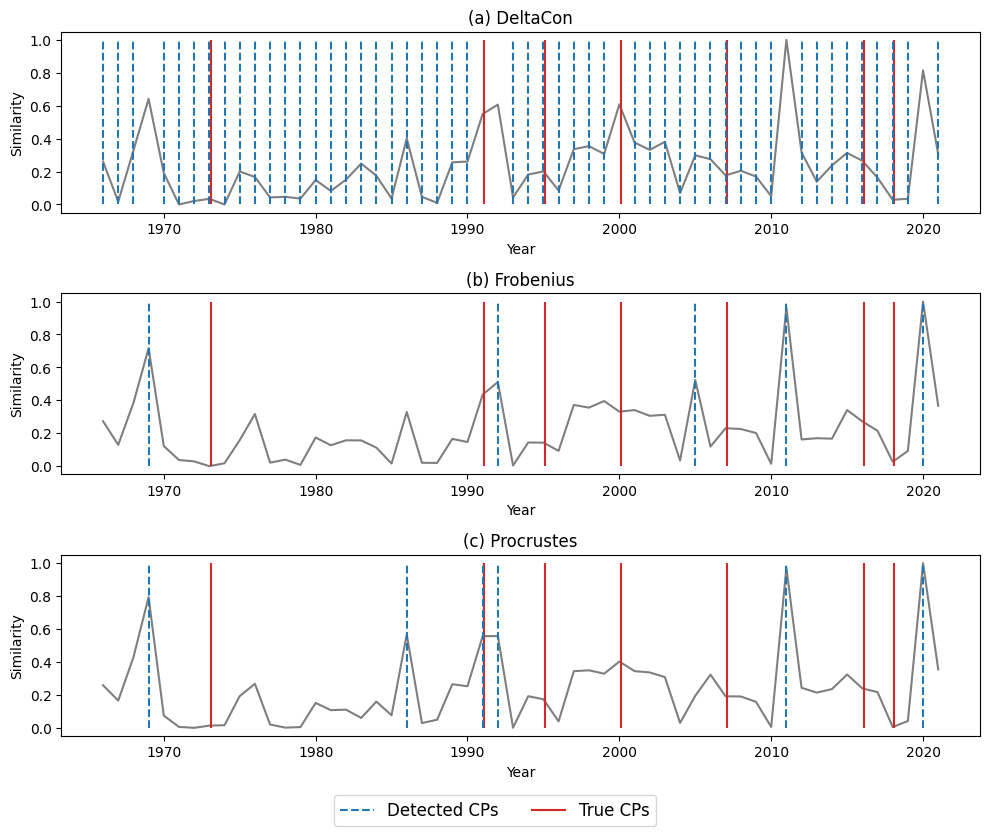

In [9]:
import matplotlib.lines as mlines
fig, axs = plt.subplots(3, 1, figsize=(10,8))

axs[0].plot(deltacon_times, deltacon_norm, label='DeltaCon', color='tab:grey')
axs[1].plot(fb_times, frobenius_norm, label='Frobenius', color='tab:grey')
axs[2].plot(pr_times, procrustes_norm, label='Procrustes', color='tab:grey')

adjusted_cps = [i+0.1 for i in true_cps if i > 1962]
labels = ['(a) DeltaCon', '(b) Frobenius', '(c) Procrustes']
detected_times = [deltacon_times, fb_times, procrustes]

for i in range(3):
    indices = detected_cps[i]
    selected_values = detected_cps[i]+1962
    
    axs[i].vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='true CPs', color='tab:red')
    axs[i].vlines(x=selected_values, ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')
    axs[i].grid(visible=False)
    axs[i].set_xlabel(rf'Year')
    axs[i].set_ylabel(rf'Similarity')
    axs[i].set_title(labels[i])

handles = [mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Detected CPs'),
           mlines.Line2D([], [], color='tab:red', linestyle='-', label='True CPs')]

fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05), fontsize='large')

plt.tight_layout()
plt.show()

## Siamese-GNN Change-Points

In [11]:
with open("../cpd-results/sage-gdp-mis-norm/avg_similarity.p", 'rb') as file:
    avg_sim_sage = pkl.load(file)

with open("../cpd-results/gat-gdp-mis-norm/avg_similarity.p", 'rb') as file:
    avg_sim_gat = pkl.load(file)

In [14]:
with open("../cpd-results/gat-gdp-mis-norm/est_cps.p", 'rb') as file:
    cps_gat = pkl.load(file)
with open("../cpd-results/sage-gdp-mis-norm/est_cps.p", 'rb') as file:
    cps_sage = pkl.load(file)

In [ ]:
detected_times_gat = [i+1962 for i in cps_gat]
detected_times_sage = [i+1962 for i in cps_sage]
times = range(1963,2018)

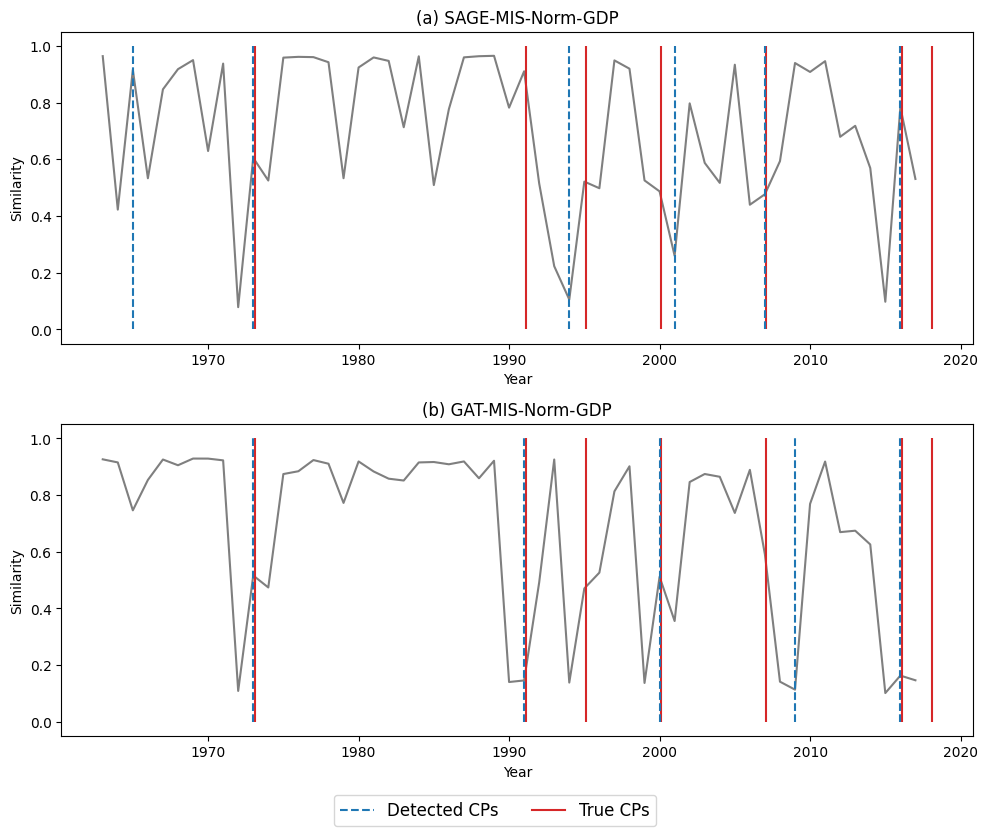

In [23]:
import matplotlib.lines as mlines
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 1, figsize=(10,8))

# Plot just one line, for example, the LAD line
axs[0].plot(times, avg_sim_sage, label='SAGE-MIS-Norm-GDP', color='tab:grey')
axs[1].plot(times, avg_sim_gat, label='GAT-MIS-Norm-GDP', color='tab:grey')

adjusted_cps = [i+0.1 for i in true_cps]

axs[0].vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='true CPs', color='tab:red')
axs[0].vlines(x=detected_times_sage, ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')
axs[0].grid(visible=False)
axs[0].set_xlabel(rf'Year')
axs[0].set_ylabel(rf'Similarity')
axs[0].set_title('(a) SAGE-MIS-Norm-GDP')

axs[1].vlines(x=adjusted_cps, ymin=0, ymax=1, linestyles='solid', label='true CPs', color='tab:red')
axs[1].vlines(x=detected_times_gat, ymin=0, ymax=1, linestyles='dashed', label='Detected CPs', color='tab:blue')
axs[1].grid(visible=False)
axs[1].set_xlabel(rf'Year')
axs[1].set_ylabel(rf'Similarity')
axs[1].set_title('(b) GAT-MIS-Norm-GDP')

handles = [mlines.Line2D([], [], color='tab:blue', linestyle='--', label='Detected CPs'),
           mlines.Line2D([], [], color='tab:red', linestyle='-', label='True CPs')]

# Add the legend to the figure
fig.legend(handles=handles, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.05), fontsize='large')

plt.tight_layout()
plt.show()